# Bayes sparse regression

# _Michael Betancourt_

# March 2018

[HTML version](https://betanalpha.github.io/assets/case_studies/bayes_sparse_regression.html)

As complex measurements convolve meaningful phenomena with more and more
extraneous phenomena, _sparsity_ is becoming an increasingly prevalent objective
in statistical analyses.  Much of this zeitgeist has been driven by the success
of frequentist methods like compressed sensing and LASSO regression, and it is
often naively assumed that these properties immediately carry over to the
corresponding Bayesian analyses.  Sparsity in a Bayesian analysis, however, is
induced by fundamentally different properties than those that induce sparsity in
a frequentist analysis.

In this case study I'll review how sparsity arises in frequentist and Bayesian
analyses and discuss the often subtle challenges in implementing sparsity in
practical Bayesian analyses.

# Fading into Irrelevance

The usual setting for sparsity is a regression over a data set containing many covariates that could possibly correlate with an outcome variate of interest.  In this circumstance sparsity is the assumption that only a few of these covariates have any meaningful correlation, although a priori we do not know exactly which covariates will be relevant and which will be irrelevant.

A sparse regression encodes this assumption to allow the data to inform both which covariates are relevant and how the relevant covariates then correlate with the outcome variate.

For example we might be interested in classifying individuals in a population into two groups, with many individual characteristics possibly influencing the probabilty of being associated with each group.  Without any sparsity
assumptions the uncertainty in the irrelevant characterisics will propagate to large uncertainties in inferred associations.  If we can isolate only the relevant covariates, however, then we can significantly reduce the uncertainties in how the covariates influence the classification.

For simplicity I will restrict the discussion to only general linear models where slopes, $\boldsymbol{\beta}$, control the influence of each covariate through some effective parameter for each observation,

$$
\theta_{n} (\mathbf{x}_{n}, \boldsymbol{\beta}, \alpha)
=
f ( \mathbf{x}_{n} \cdot \boldsymbol{\beta} + \alpha ).
$$

Because a covariate will no longer influence the model when the corresponding slope vanishes, sparsity is induced by regularizing the irrelevant slopes towards zero without affecting the relevant slopes and compromising the resulting inferences

How this sparsity is realized depends intimately on the inferential perspective that we consider.

## Inducing Sparse Decisions

_Frequentist sparsity_ is a decision making process that explicitly selects a small subset of covariates to inform the regression while discarding the rest. When executed properly this selection process can drastically reduce the size
of the data that needs to be considered and hence the computational cost of making predictions for new observations.  When executed improperly the selection process can undermine our ability to infer the variate outcome at all.

In the general linear model setting the selection of covariates is equivalent to identifying which slopes are zero and which are non-zero.  Methods like the LASSO [(Tibshirani:1996)](@Tibshirani:1996) achieve sparsity by strongly penalizing the maximum
likelihood estimator of the slopes towards small values, and then explicitly forcing a slope to zero when it falls below a given threshold during the maximum likelihood estimation.  Any slope that isn't needed to maintain the maximum likelihood fit to the observed data is forced to zero as the optimization proceeds and ultimately discarded.

For sufficiently simple data generating processes and large enough data sets these methods tend to be reasonably well-calibrated.  We will, on average, discard most of the irrelevant covariates while retaining most of the relevant covariates, and our abilty ot model the variate outcome, regardless of the exact data that we observe.

## Inducing Sparse Inferences

_Bayesian sparsity_ avoids decisions altogether and instead manifests as a distinct behavior in the posterior distribution. In particular, Bayesian sparsity arises from a posterior distribution that strongly concentrates around the neighborhood in parameter space where the irrelevant slopes are zero and hence inconsequential when making inferences.

As a penalty function can induce sparse decisions in the frequentist setting, the prior distribution can induce sparse inferences in the Bayesian setting. 
**But how exactly can a prior distribution coerce the desired concentration when we don't know which slopes are irrelevant a priori?**

It's tempting to appeal to the penalty function that is so critical to the success in the frequentist setting. In particular, if we reinterpret a sparsity-inducing penalty function as a log probability density over parameter space then does that always define a sparsity-inducing prior distribution? Unfortunately it does not.  In fact the implied prior distribution can stretch the corresponding posterior distribution _away_ from the desired neighborhood where the irrelevan slopes vanish.

The problem is that the sparsity-inducing penalty function has to influence only a single point in parameter space at any given time, whereas a sparsity-inducing prior distribution has to consider the entire parameter space at once.

## Sparsity-Inducing Estimators _versus_ Sparsity-Inducing Distributions

To highlight the difference between inducing sparsity in a point estimator and inducing sparsity in an entire distribution, let's consider the $L_{1}$ penalty at the heart of the LASSO,

$$
R_{L_{1}} ( \boldsymbol{\beta} ) = \sum_{m = 1}^{M} \lambda_{m} \left| \beta_{m} \right|.
$$

When the maximum likeihood estimate of the slope $\beta_{m}$ falls below the scale $\lambda_{m}$ it is regularized towards zero but, because the penalty is nearly flat above the scale, estimates above $\lambda_{m}$ experience negligible regularization.  

Given a suitable choice of scales for each covariate this dichotomous behavior of the penalty facilitates the suppresion of the irrelevant slopes below the selection threshold while leaving the relevant slopes undisturbed.

Interpreted as a negative log density, the $L_{1}$ penalty function implies independent Laplace priors for each of the slopes,

$$
    \pi( \boldsymbol{\beta} ) = \exp (- R_{L_{1}} ( \boldsymbol{\beta} ))
    = \prod_{m = 1}^{M} \exp (- \lambda_{m} \left| \beta_{m} \right| ).
$$

With this prior the mode of the resulting posterior distribution will coincide with the penalized maximum likelihood estimator; unfortunately the mode is not a well-posed inference drawn from the posterior distribution. Proper inferences correspond instead of posterior expectation values that are informed by the _entire_ posterior distribution.  The effect of the Laplace prior on the full posterior distribution is not nearly as useful as its effect on the mode.

Because the maximum likelihood estimator considers only a single point in parameter space at a time, it is influenced by either the regularizing behavior of the penalty below each $\lambda_{m}$ or the _laissez faire_ behavior above each $\lambda_{m}$, but not both. The expanse of the posterior distribution, however, is influenced by both of these behaviors _at the same time_. While the shape of the Laplace prior below $\lambda_{m}$ does induce some concentration of the posterior towards smaller values of $\beta_{m}$, the heavy tail also drags significant posterior probabilty far above $\lambda_{m}$.

These opposing behaviors induce regrettable features in the posterior for both the irrelevant slopes, which leak significant probability mass towards undesired large values, and relevant slopes, which are overshrunk towards smaller values.  The former prevents us from identifying the irrelevant parameters while the latter biases our inferences.  Moreover, in both cases the
marginal posteriors become much more diffuse than warranted which inflates our inferential uncertainties.

If we want to induce sparsity in Bayesian decisions then we need a **prior distribution with a more holistic approach to regularization.** Luckily enough, we have **the horseshoe.**

# Constructing Prior Distributions That Induce Sparsity

To implement Bayesian sparsity we need a prior distribution that allows the data to collapse the entire marginal posterior for each slope towards relevance or irrelevance, but not both. In doing so we need to carefully define exactly what values of the slopes are consequential to the final inference and what values are not.

## Sparsity-Inducing Shapes

In order to provide the desired flexibility in the posterior for each slope we need a prior distribution that enforces a global scale while also giving each of slopes the flexibilty to transcend that scale as needed.  Because we don't know which slopes will need that flexibilty the desired prior will have to be exchangeable with respect to the slopes and hence manifest a hierachical structure.

The _horseshoe_ prior [@CarvalhoEtAl:2009] accomplishes this flexibility by setting the scale for each component to the product of a global scale, $\tau$, and a local scale, $\lambda_{m}$, each of which are themselves unknown parameters,

$$
    \begin{align*}
        \beta_{m}   &\sim \mathcal{N}(0, \tau \cdot \lambda_{m}) \\[0.2cm]
        \lambda_{m} &\sim \text{Half-}\mathcal{C}(0, 1)   \\[0.2cm]
        \tau        &\sim \text{Half-}\mathcal{C}(0, \tau_{0}).
    \end{align*}
$$

The heavy-tailed Cauchy prior distribution for the local scales allows the data to push each to large values as needed, which then push the corresponding slopes above the global scale, $\tau$. By making the global scale itself a parameter we also allow the data to refine the scale beyond our prior judgement of $\tau_{0}$.

An immediate problem with the horseshoe prior is that the slopes that transcend the global scale are otherwise unregularized, leaving their posteriors to diffuse to extremely large values. This behavior allows nonidentification or weak identification of the likelihood to propagate to the posterior and compromise the validity of the resulting inferences.  The _Finnish horseshoe_
[@PiironenEtAl:2017a] remedies this vulnerability by introducing another level to the prior hierarchy,

$$
    \begin{align*}
        \beta_{m}           &\sim \mathcal{N} (0, \tau \cdot \tilde{\lambda}_{m})\\[0.2cm]
        \tilde{\lambda}_{m} &=    \frac{c \lambda_{m}}{\sqrt{ c^{2} + \tau^{2} \lambda_{m}^{2}}}\\[0.2cm]
        \lambda_{m}         &\sim \text{Half-}\mathcal{C} (0, 1)\\[0.2cm]
        c^{2}               &\sim \text{Inv-}\mathcal{G} \, (\frac{\nu}{2}, \frac{\nu}{2} s^{2})\\[0.2cm]
        \tau                &\sim \text{Half-}\mathcal{C} (0, \tau_{0}).
    \end{align*}
$$

Integrating the new scale, $c$, out of the distribution implies a marginal $\text{Student-}t\,(\nu,0,s)$ prior for each of the slopes, at least sufficiently far above the global scale.  Setting $\nu$ and $s$ appropriately then ensures that we can contain with the posterior within a few multiples of $s$ around zero.

## Sparsity-Inducing Thresholds

With the shape of a sparsity-inducing prior established we are left only with determining the prior hyperparameter $\tau_{0}$ which effectively determines the scale below which slopes are irrelevant to the modeling of the output variate. The subtlety with specifying $\tau_{0}$ is that irrelevance is determined not by the prior distribution itself but rather our _measurement process_ -- the contribution of a slope is negligible only when it is indistinguishable from the inherent variabiltiy of our observations. As always the consequences of the prior depend on the context of the likelihood [@GelmanEtAl:2017].

Let's presume that we will model our measurement process as a linear regression,

$$
    y_{n} \sim\mathcal{N}(\mathbf{x}_{n} \cdot \boldsymbol{\beta} + \alpha, \sigma).
$$

The measurement variability, $\sigma$, provides a natural scale for irrelevance in this model.

If we assume that the covariates are independent and distributed around zero with unit variation then a slope on the order of $\sigma$ will yield an individual response, $x_{nm} \beta_{m} \approx \sigma$, that would be hard to discriminate from the expected variation of the measurement itself a priori. Consequently $\tau_{0} = \sigma$ seems a reasonable assumption.

When we consider the posterior behavior, however, we have to recognize that the data will typically inform our inferences beyond the scale of the measurement variability - with $N$ independent observations we will be sensitive to effects as small as $\sigma/\sqrt{N}$. If we ignore the number of observations then the consequences of the resulting prior will change with the size of the data! This suggests instead that we take $\tau_{0}=\sigma/\sqrt{N}$.

Our logic so far has relied on the expected contribution from each slope individually. That tails of the horseshoe priors, however, are heavy enough that when we consider the contribution from many slopes at once we will see at least a few will exceed the irrelevance threshold and significantly effect the variate-covariate relationship. In order to avoid this ensemble behavior we have to reduce our prior scale even further to

$$
    \tau_{0} = \frac{m_{0}}{M - m_{0}} \frac{\sigma}{\sqrt{N}},
$$

where $m_{0}$ is the expected number of relevant slopes. The sparsity induced by the corresponding threshold is only weakly sensitive to $m_{0}$, so a reasonable estimate is typically sufficient.

If we move away from pure linear regression then this argument has to be modified to account for nonlinearities in the measurement process. [@PiironenEtAl:2017a] derives approximate scales appropriate to general linear models. In order to facilitate the optimal performance of the horseshoe family of prior distributions we must take care to ensure that the prior scale is compatible with the measurement process.

# Experiments

To demonstrate the subtleties in implementing sparsity in a Bayesian analysis
let's consider data simulated from a linear regression model,

`N` = Number of data

`M` = Number of covariates

Beware of a transpose notation: the model matrix is `X'` (with `N` rows and `M` columns). 

The intercept `alpha` is given the fixed value 3.

The vector `beta` of regression coefficients has `M` entries.

A 5% of these betas have absolute value around 10, either positive (about half of them) or negative (the other half).

The remaining 95% betas have non-significant values, around 0.

The model matrix is filled with random standared normal values.

In [2]:
writeLines(readLines("generate_data.stan"))

transformed data {
  int<lower=0> M = 200;
  int<lower=0> N = 100;
  real alpha = 3;
  real sigma = 1;
  real<lower=0, upper=1> sig_prob = 0.05;
}

generated quantities {
  matrix[M, N] X;
  real y[N];

  vector[M] beta;
  for (m in 1:M) {
    if (bernoulli_rng(sig_prob))
      if (bernoulli_rng(0.5))
        beta[m] = normal_rng(10, 1);
      else
        beta[m] = normal_rng(-10, 1);
    else
      beta[m] = normal_rng(0, 0.25);
  }

  for (n in 1:N) {
    for (m in 1:M)
      X[m, n] = normal_rng(0, 1);

    y[n] = normal_rng(X[1:M,n]' * beta + alpha, sigma);
  }
}


The covariates are all independently distributed around zero with unit variance, and there is a population of both large, relevant slopes and small, irrelevant slopes. Moreover, the data are collinear, with more covariates than observations, which implies a non-identified likelihood.

We begin by simulating a measurement,

In [3]:
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Loading required package: StanHeaders


rstan version 2.26.11 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [4]:
util <- new.env()
source('stan_utility.R', local=util)
source('plot_utility.R', local=util)

In [6]:
start.time <- Sys.time()

fit <- stan(file='generate_data.stan', iter=1,
            chains=1, seed=194838, algorithm="Fixed_param")

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: Iteration: 1 / 1 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0 seconds (Warm-up)
Chain 1:                0.001 seconds (Sampling)
Chain 1:                0.001 seconds (Total)
Chain 1: 


Time difference of 0.300848 secs

In [7]:
X <- extract(fit)$X[1,,]
y <- extract(fit)$y[1,]
N <- dim(X)[2]
M <- dim(X)[1]
beta_true <- extract(fit)$beta[1,]

In [8]:
stan_rdump(c("N", "M", "X", "y", "beta_true"), file="linear_regression.data.R")


Only 7 of the simulated slopes are large enough to significantly effect
the regression, with the other slopes left largely irrelevant.



In [9]:
input_data <- read_rdump("linear_regression.data.R")

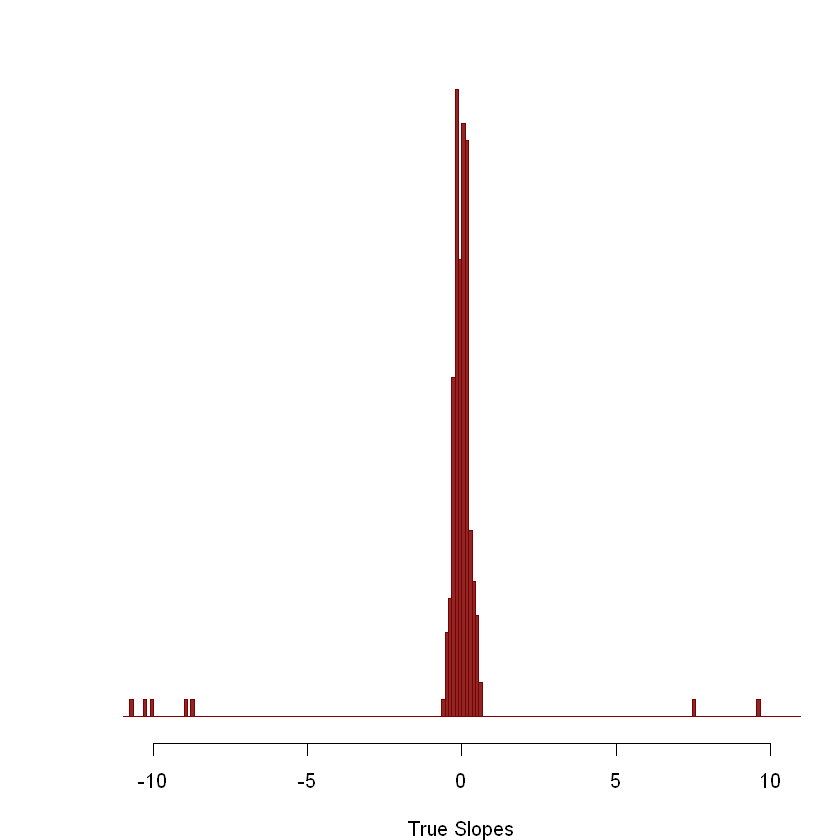

In [10]:
c_dark <- c("#8F2727")
c_dark_highlight <- c("#7C0000")

par(mar = c(4, 4, 0.5, 0.5))
hist(input_data$beta_true, main="", col=c_dark, border=c_dark_highlight,
     xlab="True Slopes", yaxt='n', ylim=c(0, 40), ylab="",
     breaks=11*(-100:100)/100)

Our ability to recover these relevant slopes will depend intimately on the prior
we incorporate into our Bayesian model.

## Uniform Prior

Let's begin with a uniform prior over the slopes,

In [11]:
writeLines(readLines("linear_regression_unif.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  // No priors on the slopes
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}


In [12]:
start.time <- Sys.time()

unif_fit <- stan(file='linear_regression_unif.stan',data=input_data, seed=4938483)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 14 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 3986 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 4.18, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
htt

Time difference of 1.570953 mins


The uniform prior allows that non-identifiabilty of the likelihood to propagate
to the posterior.  The fit of the resulting posterior unsurprisingly fails in
spectacular fashion, with vanishing effective sample sizes, large $\hat{R}$, and
failing HMC diagnostics.



In [13]:
capture.output(util$check_n_eff(unif_fit))[1:5]
capture.output(util$check_rhat(unif_fit))[1:5]
util$check_div(unif_fit)
util$check_treedepth(unif_fit)
util$check_energy(unif_fit)

[1] "[1] \"n_eff / iter for parameter beta[1] is 0.00077021465660359!\"" 
[2] "[1] \"n_eff / iter for parameter beta[2] is 0.000734315280518184!\""
[3] "[1] \"n_eff / iter for parameter beta[3] is 0.000609367690223646!\""
[4] "[1] \"n_eff / iter for parameter beta[5] is 0.00051969125508625!\"" 
[5] "[1] \"n_eff / iter for parameter beta[6] is 0.000559052539107211!\""

[1] "[1] \"Rhat for parameter beta[1] is 2.49706105886264!\""
[2] "[1] \"Rhat for parameter beta[2] is 3.17310168754711!\""
[3] "[1] \"Rhat for parameter beta[3] is 3.41474761264633!\""
[4] "[1] \"Rhat for parameter beta[4] is 2.13152611299226!\""
[5] "[1] \"Rhat for parameter beta[5] is 5.87145563808637!\""

[1] "14 of 4000 iterations ended with a divergence (0.35%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "3986 of 4000 iterations saturated the maximum tree depth of 10 (99.65%)"
[1] "  Run again with max_depth set to a larger value to avoid saturation"
[1] "Chain 1: E-BFMI = 0.177709201858234"
[1] "Chain 2: E-BFMI = 0.0780454881699764"
[1] "Chain 3: E-BFMI = 0.171831514795237"
[1] "Chain 4: E-BFMI = 0.131467346140296"
[1] "  E-BFMI below 0.2 indicates you may need to reparameterize your model"


The fit does, however, exhibit some of the massive uncertainty inherent to the non-identified posterior. This is evident from looking at the extreme extent of the marginal posteriors for each slope, here visualized as nested intervals ranging from the median in dark red to an 80% posterior interval in the lightest red. The relevant slopes are indicated by dashed grey lines and
the truth slopes are shown in black. Note the scale of the y-axis here surpassing thousands when the largest slopes shouldn't be much magnitudes much greater than ten.

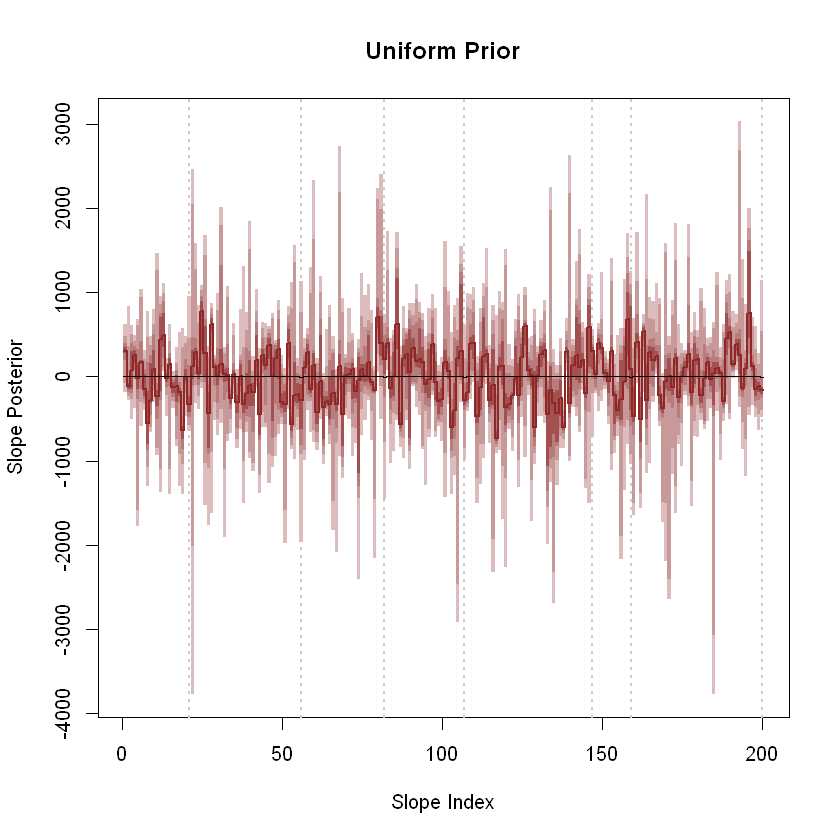

In [14]:
util$plot_post_quantiles(unif_fit, input_data, "Uniform Prior")

Subtracting the true slopes from the inferred slopes, with black now indicating the desired zero baseline, doesn't show any inaccuracy but only because the posterior is so non-identified.

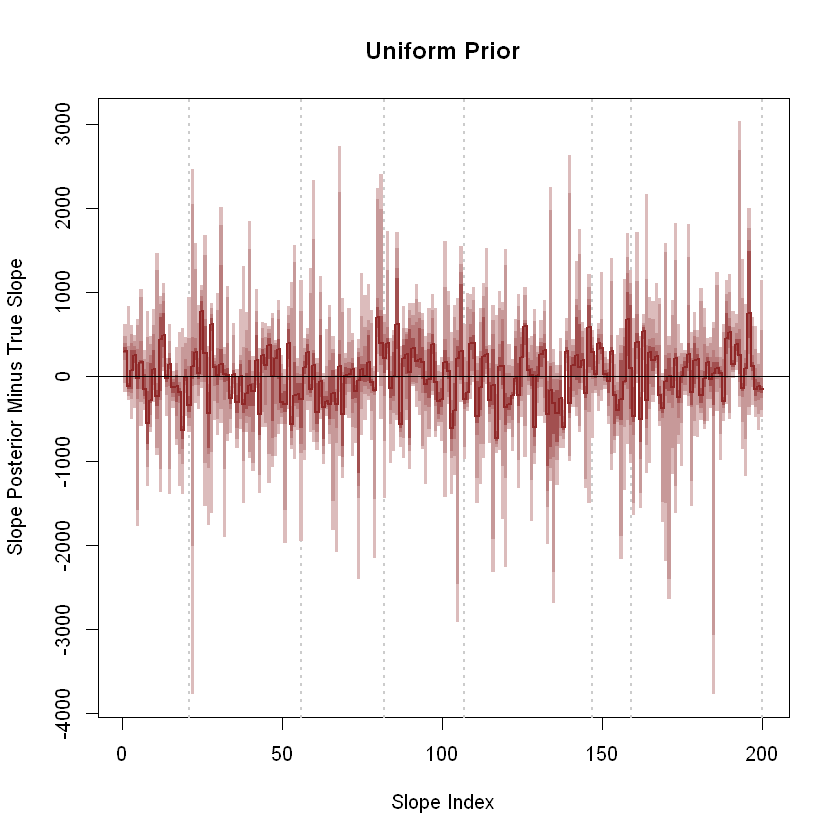

In [15]:
util$plot_residual_quantiles(unif_fit, input_data, "Uniform Prior")


The intercept and measurement variability are better identified, but only
because of their weakly informative priors.



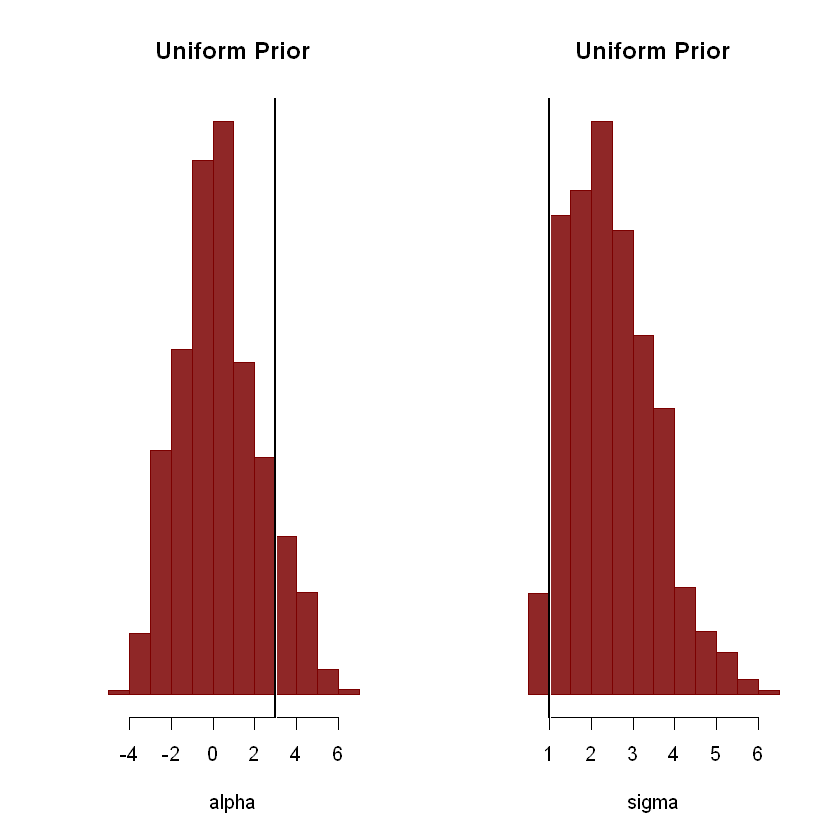

In [16]:
util$plot_aux_posteriors(unif_fit, "Uniform Prior")

## Narrow Weakly Informative Prior

We definitely need a prior to compensate for the non-identified likelihood, but just how much prior informationt do we need?  Let's try a weakly-informative prior for all of the slopes that strongly concentrates below the scale of the measurement variability.

In [17]:
writeLines(readLines("linear_regression_narrow.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  // Strongly regularizing priors on the slopes
  beta ~ normal(0, 1);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}


In [18]:
start.time <- Sys.time()

narrow_fit <- stan(file='linear_regression_narrow.stan', data=input_data, seed=4938483)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Time difference of 43.84018 secs


The fit is now much better behaved,



In [19]:
util$check_all_diagnostics(narrow_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "0 of 4000 iterations ended with a divergence (0%)"
[1] "0 of 4000 iterations saturated the maximum tree depth of 10 (0%)"
[1] "E-BFMI indicated no pathological behavior"


but the extreme regularization biases the marginal posteriors for the relevant slopes, again shown with grey dashed lines, far below their true values, again in black.

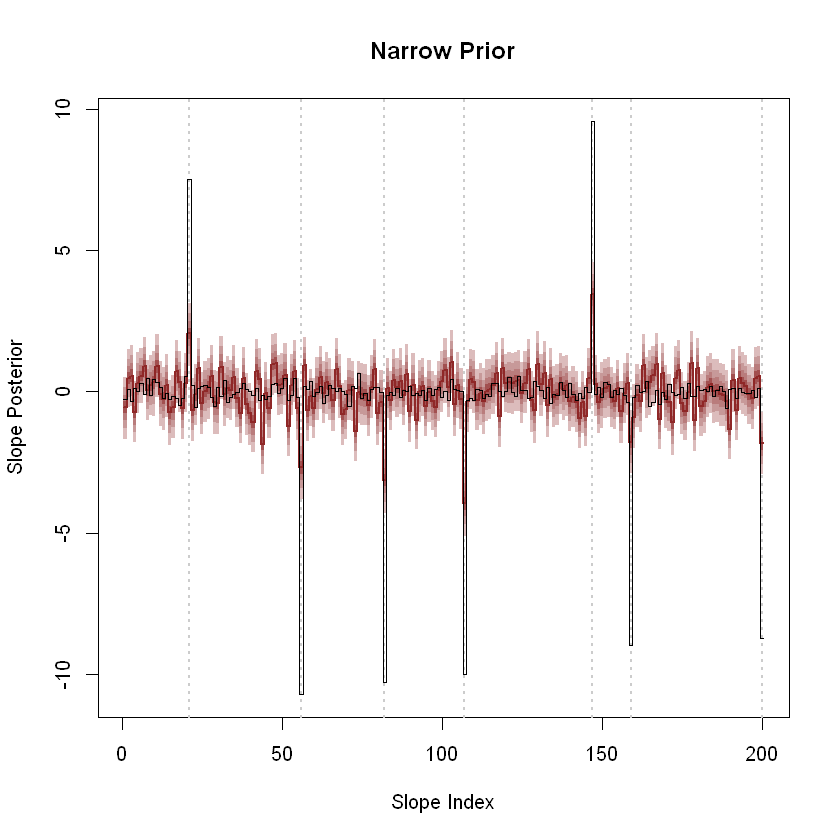

In [20]:
util$plot_post_quantiles(narrow_fit, input_data, "Narrow Prior")

This is even more evident if we subtract the true values.

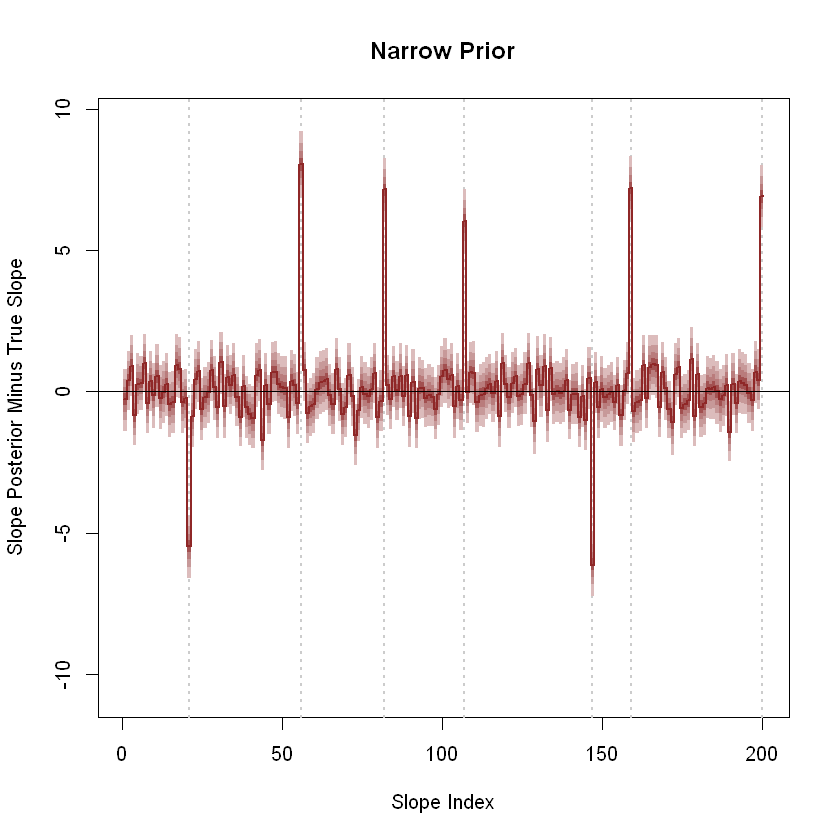

In [21]:
util$plot_residual_quantiles(narrow_fit, input_data, "Narrow Prior")

Additionally, the inferred measurement variability is biased quite high in order to compensate for the underestimated relevant slopes.

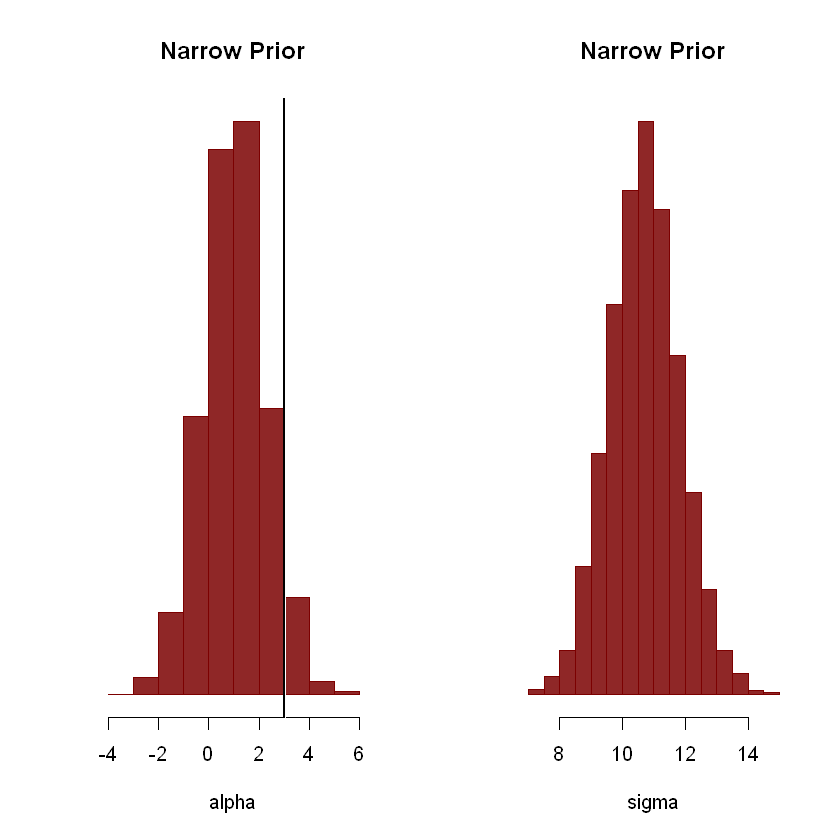

In [22]:
util$plot_aux_posteriors(narrow_fit, "Narrow Prior")

## Wide Weakly Informative Prior

Would a weakly informative prior work if we expanded the scale so to encompass the breadth of the true slopes?

In [23]:
writeLines(readLines("linear_regression_wide.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  // Weakly regularizing priors on the slopes
  beta ~ normal(0, 10);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}


In [24]:
start.time <- Sys.time()

wide_fit <- stan(file='linear_regression_wide.stan', data=input_data, seed=4938483)

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 15 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 2717 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.08, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
htt

Time difference of 1.370595 mins

The fit diagnostics hint at trouble, which is not unexpected given that the wider prior allows more of the likelihood non-identifiabilty to spread to the posterior.

In [25]:
util$check_all_diagnostics(wide_fit)

[1] "n_eff / iter looks reasonable for all parameters"
[1] "Rhat looks reasonable for all parameters"
[1] "15 of 4000 iterations ended with a divergence (0.375%)"
[1] "  Try running with larger adapt_delta to remove the divergences"
[1] "2717 of 4000 iterations saturated the maximum tree depth of 10 (67.925%)"
[1] "  Run again with max_depth set to a larger value to avoid saturation"
[1] "Chain 1: E-BFMI = 0.107500671527903"
[1] "Chain 2: E-BFMI = 0.0587389898403336"
[1] "Chain 3: E-BFMI = 0.050390075843774"
[1] "Chain 4: E-BFMI = 0.0760364629127862"
[1] "  E-BFMI below 0.2 indicates you may need to reparameterize your model"


More importantly, the wide prior offers little regularization to the many slopes that are expected to be negligible. The resulting marginal posteriors exhibit little contraction away from the prior.

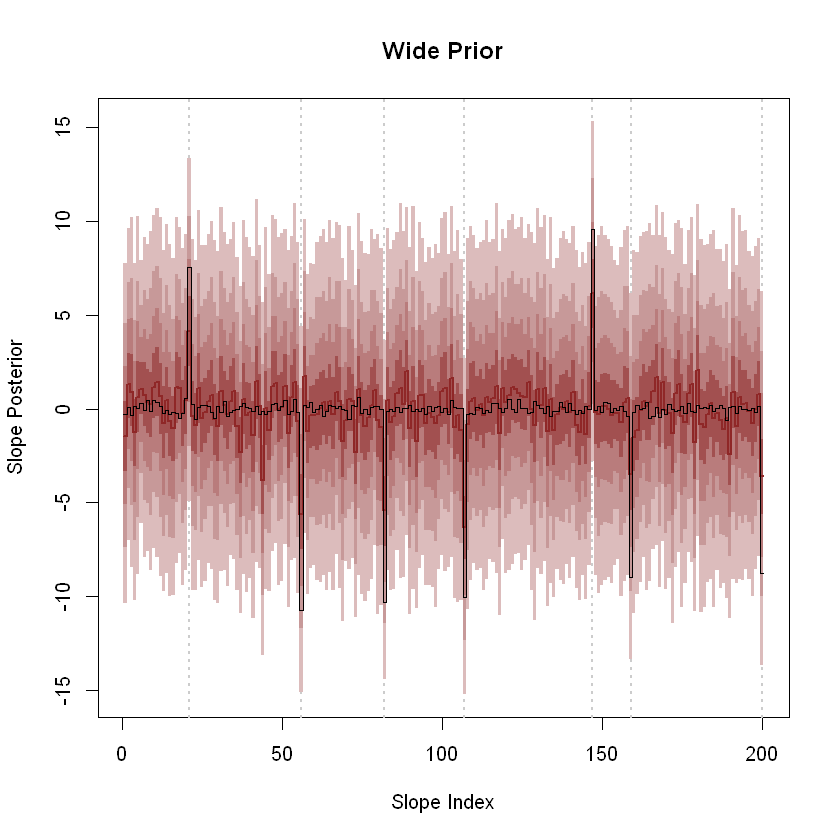

In [26]:
util$plot_post_quantiles(wide_fit, input_data, "Wide Prior")

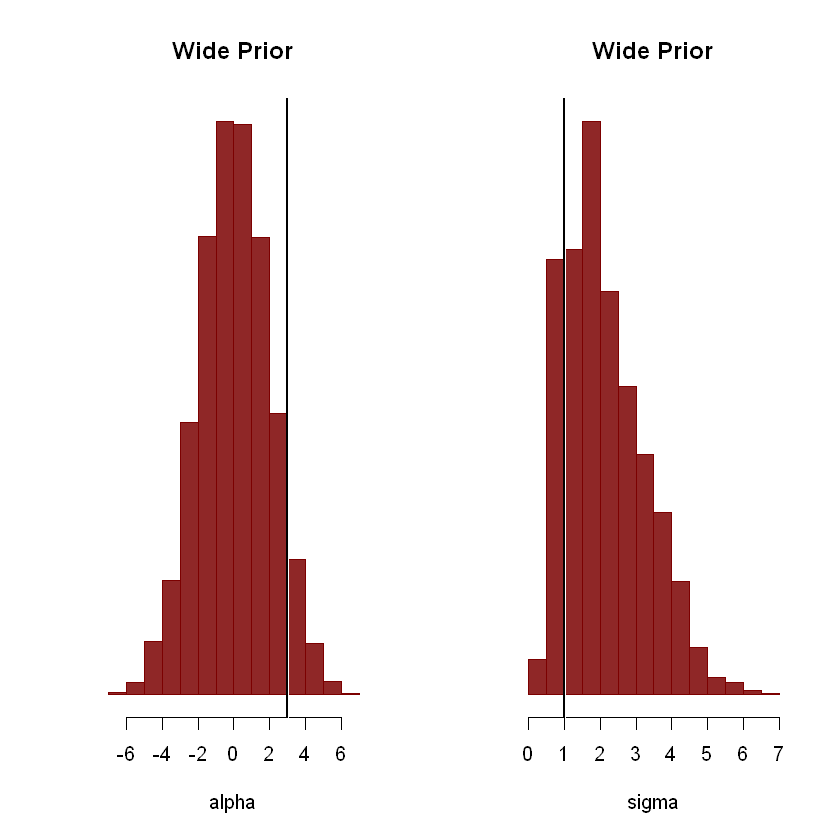

In [27]:
util$plot_aux_posteriors(wide_fit, "Wide Prior")

The residuals don't demonstrate any significant inaccuracy, but only because of the large uncertainties.

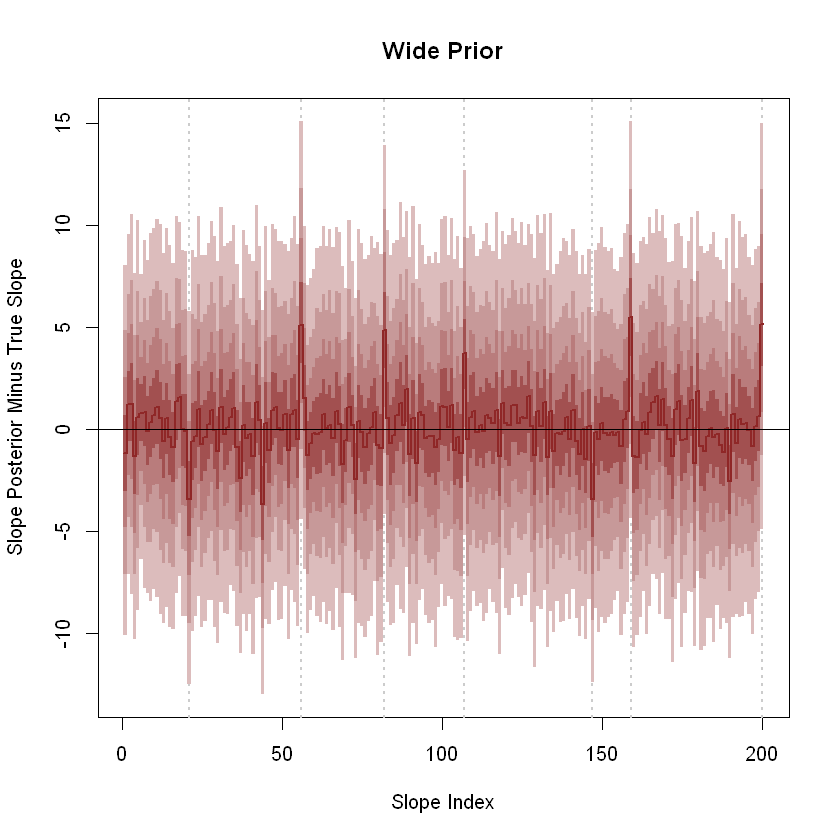

In [28]:
util$plot_residual_quantiles(wide_fit, input_data, "Wide Prior")

## Laplace Prior

If we want to isolate the relevant slopes then we have to encode the assumption of sparsity into our prior distribution. Before considering the family of horseshoe priors, however, let's take a look at the Laplace prior motivated by a naive translation of the frequentist LASSO.

In [29]:
writeLines(readLines("linear_regression_laplace.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

parameters {
  vector[M] beta;
  real alpha;
  real<lower=0> sigma;
}

model {
  // Strongly regularizing priors
  beta ~ double_exponential(0, 1);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}


In [30]:
start.time <- Sys.time()

laplace_fit<-stan(file='linear_regression_laplace.stan',data=input_data, seed=4938483,
                    control=list(adapt_delta=0.99, max_treedepth=12))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.31, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 2.050727 mins


Even with the large treedepths and small adaptation target, `adapt_delta`, the
fit with the Laplace prior exhibits slow mixing.



In [31]:
util$check_n_eff(laplace_fit)

[1] "n_eff / iter looks reasonable for all parameters"


In [32]:
util$check_rhat(laplace_fit)

[1] "Rhat for parameter sigma is 1.23843460113634!"
[1] "Rhat for parameter lp__ is 1.33488834759021!"
[1] "  Rhat above 1.1 indicates that the chains very likely have not mixed"


In [33]:
util$check_div(laplace_fit)

[1] "0 of 4000 iterations ended with a divergence (0%)"


In [34]:
util$check_treedepth(laplace_fit, 12)

[1] "0 of 4000 iterations saturated the maximum tree depth of 12 (0%)"


In [35]:
util$check_energy(laplace_fit)

[1] "Chain 1: E-BFMI = 0.0281729859485037"
[1] "Chain 2: E-BFMI = 0.0431108361569113"
[1] "Chain 3: E-BFMI = 0.0349524987532217"
[1] "Chain 4: E-BFMI = 0.0652303087296656"
[1] "  E-BFMI below 0.2 indicates you may need to reparameterize your model"


The Laplace prior finally yields some of the behavior that we need to encode sparsity, resulting in much better behavior compared to the failures up to this point. Still, the relevant slopes exhibit signs of overregularization while the irrelevant slopes aren't as strongly regularized as we'd like.

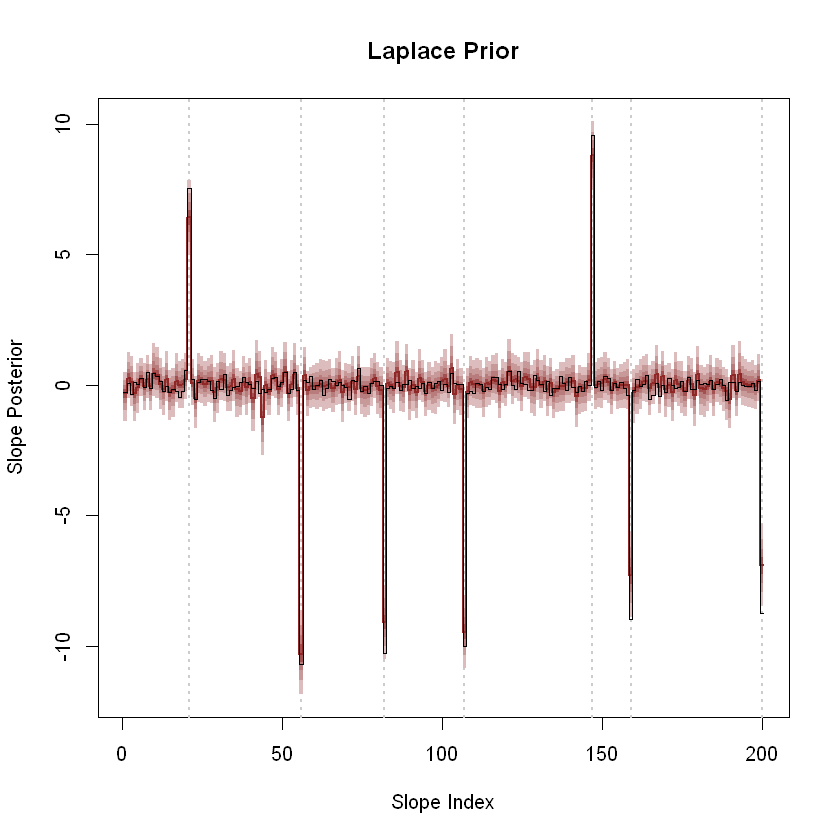

In [36]:
util$plot_post_quantiles(laplace_fit, input_data, "Laplace Prior")

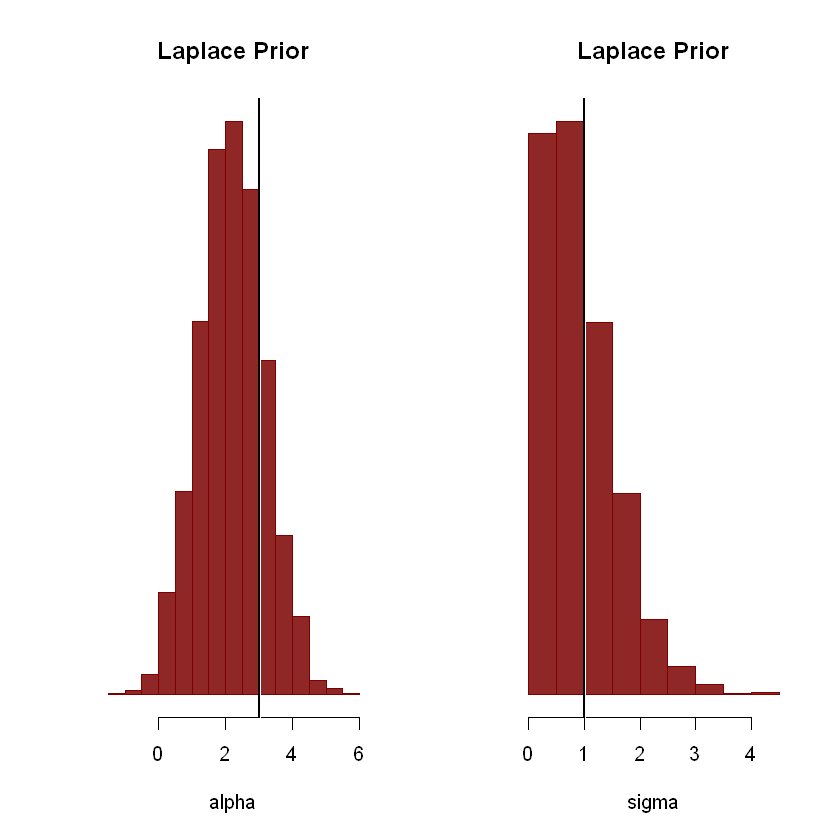

In [37]:
util$plot_aux_posteriors(laplace_fit, "Laplace Prior")

This is particularly evident once we subtract the true slopes from the recovered posteriors.

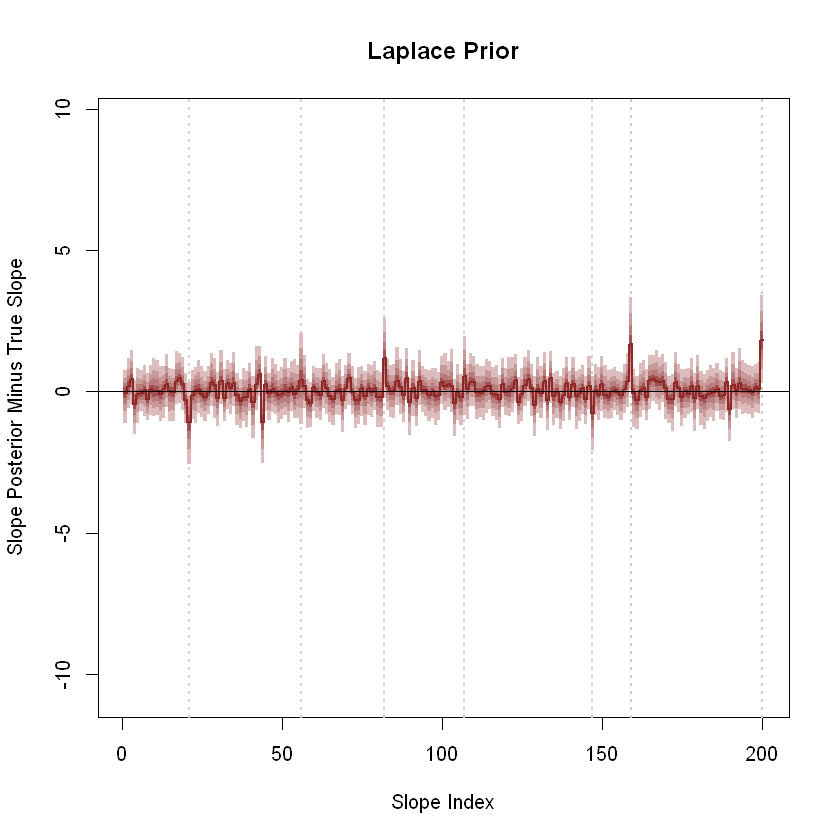

In [38]:
util$plot_residual_quantiles(laplace_fit, input_data, "Laplace Prior")

## The Horseshoe

The _horseshoe_ prior [@CarvalhoEtAl:2009] accomplishes this flexibility by setting the scale for each component to the product of a global scale, $\tau$, and a local scale, $\lambda_{m}$, each of which are themselves unknown parameters,

$$
    \begin{align*}
        \beta_{m}   &\sim \mathcal{N}(0, \tau \cdot \lambda_{m}) \\[0.2cm]
        \lambda_{m} &\sim \text{Half-}\mathcal{C}(0, 1)   \\[0.2cm]
        \tau        &\sim \text{Half-}\mathcal{C}(0, \tau_{0}).
    \end{align*}
$$

In order to encode proper inferential sparsity into our Bayesian analysis we need to consider the horseshoe or variants thereof. Let's first consider the classic horseshoe with the often recommended scale $\tau_{0}=\sigma$.

In [39]:
writeLines(readLines("linear_regression_horseshoe.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

parameters {
  vector[M] beta_tilde;
  vector<lower=0>[M] lambda;
  real<lower=0> tau_tilde;
  real alpha;
  real<lower=0> sigma;
}

model {
  // tau ~ cauchy(0, sigma)
  // beta ~ normal(0, tau * lambda)
  vector[M] beta = beta_tilde .* lambda * sigma * tau_tilde;

  beta_tilde ~ normal(0, 1);
  lambda ~ cauchy(0, 1);
  tau_tilde ~ cauchy(0, 1);

  alpha ~ normal(0, 2);
  sigma ~ normal(0, 2);

  y ~ normal(X' * beta + alpha, sigma);
}


In [40]:
start.time <- Sys.time()   # It takes forever on some systems

horseshoe_fit <- stan(file='linear_regression_horseshoe.stan',
                      data=input_data, seed=4938483,
                      control=list(adapt_delta=0.99, max_treedepth=15))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 167 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 1000 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 15. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.05, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
ht

Time difference of 32.32242 mins

Unfortunately, the fit isn't great.  The horseshoe does have a reputation for being challenging to fit in general, but its lack of regularization of the relevant slopes is particularly troublesome in the context of the non-identified likelihood.

In [41]:
util$check_n_eff(horseshoe_fit)

[1] "n_eff / iter looks reasonable for all parameters"


In [42]:
util$check_rhat(horseshoe_fit)

[1] "Rhat looks reasonable for all parameters"


In [43]:
util$check_div(horseshoe_fit)

[1] "167 of 4000 iterations ended with a divergence (4.175%)"
[1] "  Try running with larger adapt_delta to remove the divergences"


In [44]:
util$check_treedepth(horseshoe_fit, 15)

[1] "1000 of 4000 iterations saturated the maximum tree depth of 15 (25%)"
[1] "  Run again with max_depth set to a larger value to avoid saturation"


In [45]:
util$check_energy(horseshoe_fit)

[1] "Chain 1: E-BFMI = 0.126777962801733"
[1] "Chain 2: E-BFMI = 0.0726092241938192"
[1] "Chain 3: E-BFMI = 0.0917632817744948"
[1] "Chain 4: E-BFMI = 0.0519306402035443"
[1] "  E-BFMI below 0.2 indicates you may need to reparameterize your model"



Although the fit isn't trustworthy, we do see some sparsity manifesting in the
marginal posteriors for the irrelevant slopes.



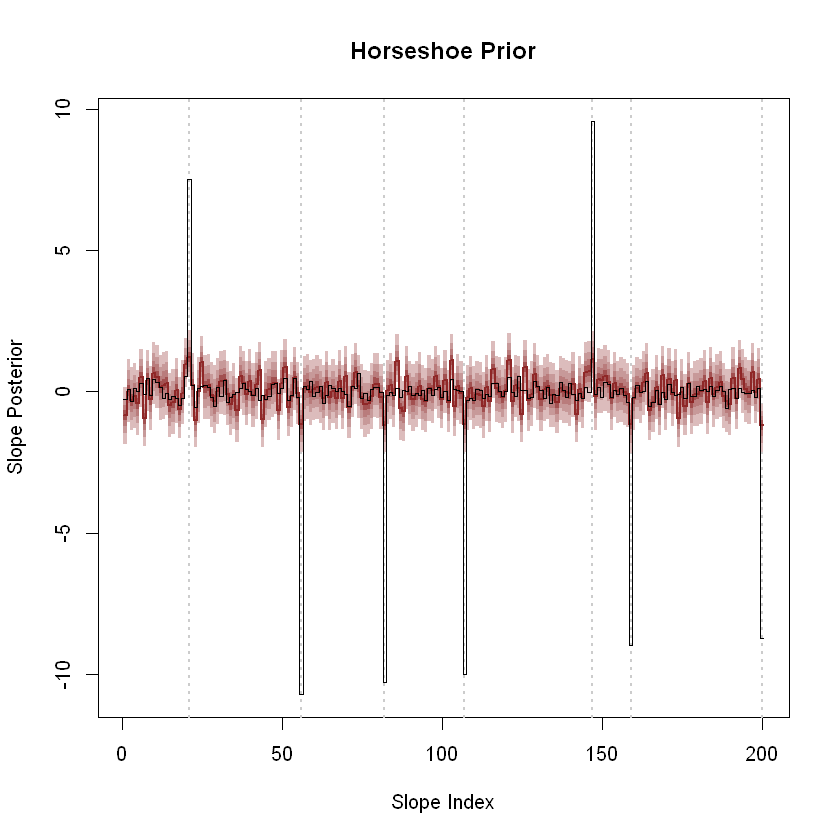

In [46]:
util$plot_post_quantiles(horseshoe_fit, input_data, "Horseshoe Prior")


Unfortunately the stress of the non-identified likelihood prevents the horseshoe
prior from enabling accurate fit of the relevant slopes.



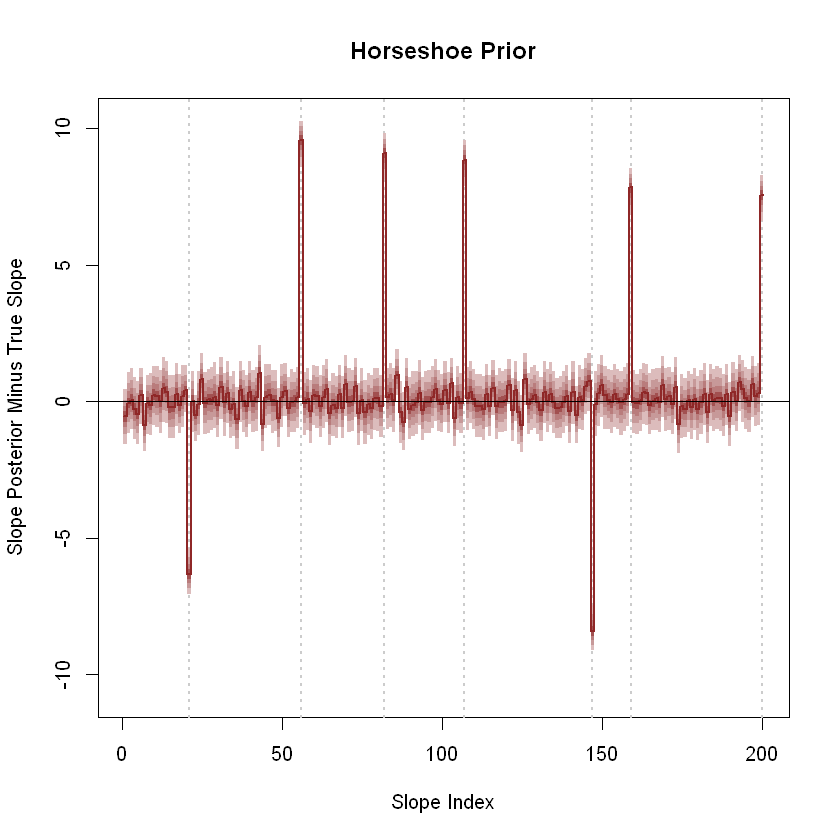

In [47]:
util$plot_residual_quantiles(horseshoe_fit, input_data, "Horseshoe Prior")


The marginal posterior for the measurement variability, $\sigma$, also
exhibits the poor mixing of the fit.



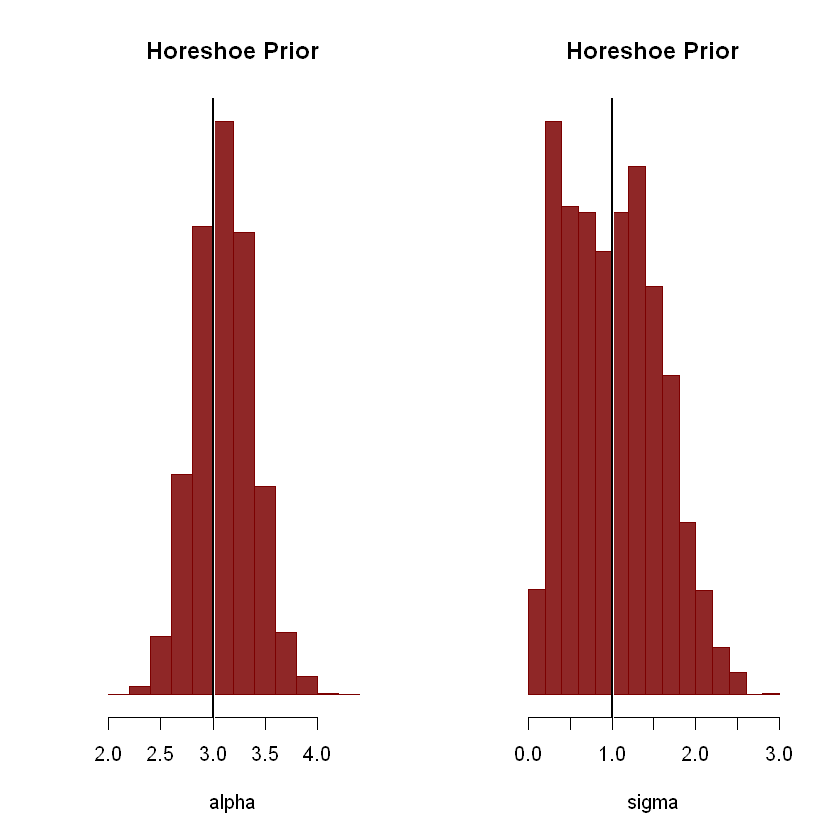

In [48]:
util$plot_aux_posteriors(horseshoe_fit, "Horeshoe Prior")

## The Finnish Horseshoe

Finally we can consider incorporating a Finnish horseshoe into our model.
Here we assume 10 large slopes and tune the extra level of regularization to
place most of the prior mass below a magnitude of 10.

An immediate problem with the horseshoe prior is that the slopes that transcend the global scale are otherwise unregularized, leaving their posteriors to diffuse to extremely large values. This behavior allows nonidentification or weak identification of the likelihood to propagate to the posterior and compromise the validity of the resulting inferences.  The _Finnish horseshoe_
[@PiironenEtAl:2017a] remedies this vulnerability by introducing another level to the prior hierarchy,

$$
    \begin{align*}
        \beta_{m}           &\sim \mathcal{N} (0, \tau \cdot \tilde{\lambda}_{m})\\[0.2cm]
        \tilde{\lambda}_{m} &=    \frac{c \lambda_{m}}{\sqrt{ c^{2} + \tau^{2} \lambda_{m}^{2}}}\\[0.2cm]
        \lambda_{m}         &\sim \text{Half-}\mathcal{C} (0, 1)\\[0.2cm]
        c^{2}               &\sim \text{Inv-}\mathcal{G} \, (\frac{\nu}{2}, \frac{\nu}{2} s^{2})\\[0.2cm]
        \tau                &\sim \text{Half-}\mathcal{C} (0, \tau_{0}).
    \end{align*}
$$

Integrating the new scale, $c$, out of the distribution implies a marginal $\text{Student-}t\,(\nu,0,s)$ prior for each of the slopes, at least sufficiently far above the global scale.  Setting $\nu$ and $s$ appropriately then ensures that we can contain with the posterior within a few multiples of $s$ around zero.

In [49]:
writeLines(readLines("linear_regression_finnish_horseshoe.stan"))

data {
  int<lower=1> N; // Number of data
  int<lower=1> M; // Number of covariates
  matrix[M, N] X;
  real y[N];
}

// slab_scale = 5, slab_df = 25 -> 8 divergences

transformed data {
  real m0 = 10;           // Expected number of large slopes
  real slab_scale = 3;    // Scale for large slopes
  real slab_scale2 = square(slab_scale);
  real slab_df = 25;      // Effective degrees of freedom for large slopes
  real half_slab_df = 0.5 * slab_df;
}

parameters {
  vector[M] beta_tilde;
  vector<lower=0>[M] lambda;
  real<lower=0> c2_tilde;
  real<lower=0> tau_tilde;
  real alpha;
  real<lower=0> sigma;
}

transformed parameters {
  vector[M] beta;
  {
    real tau0 = (m0 / (M - m0)) * (sigma / sqrt(1.0 * N));
    real tau = tau0 * tau_tilde; // tau ~ cauchy(0, tau0)

    // c2 ~ inv_gamma(half_slab_df, half_slab_df * slab_scale2)
    // Implies that marginally beta ~ student_t(slab_df, 0, slab_scale)
    real c2 = slab_scale2 * c2_tilde;

    vector[M] lambda_tilde =
      sqrt( c2 


As with any Finn, the Finnish horseshoe can be a bit stubborn and we have to
push the limits of Hamiltonian Monte Carlo a bit to resolve all of the
structure it induces in the posterior distribution.  With some tuning, however,
we recover a good fit.



In [50]:
start.time <- Sys.time()   # It takes forever on some systems

finnish_fit <- stan(file='linear_regression_finnish_horseshoe.stan',
                    data=input_data, seed=4938483,
                    control=list(adapt_delta=0.99, max_treedepth=15))

end.time <- Sys.time()
computing.time <- end.time - start.time
computing.time

Warning message:
"There were 6 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess"
Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess"


Time difference of 2.442273 mins

In [51]:
util$check_n_eff(finnish_fit)

[1] "n_eff / iter looks reasonable for all parameters"


In [52]:
util$check_rhat(finnish_fit)

[1] "Rhat looks reasonable for all parameters"


In [53]:
util$check_div(finnish_fit)

[1] "6 of 4000 iterations ended with a divergence (0.15%)"
[1] "  Try running with larger adapt_delta to remove the divergences"


In [54]:
util$check_treedepth(finnish_fit, 15)

[1] "0 of 4000 iterations saturated the maximum tree depth of 15 (0%)"


In [55]:
util$check_energy(finnish_fit)

[1] "Chain 3: E-BFMI = 0.184213072706552"
[1] "  E-BFMI below 0.2 indicates you may need to reparameterize your model"



The Finnish horseshoe induces narrow posteriors for both the relevant and
irrelevant slopes without compromising accuracy.



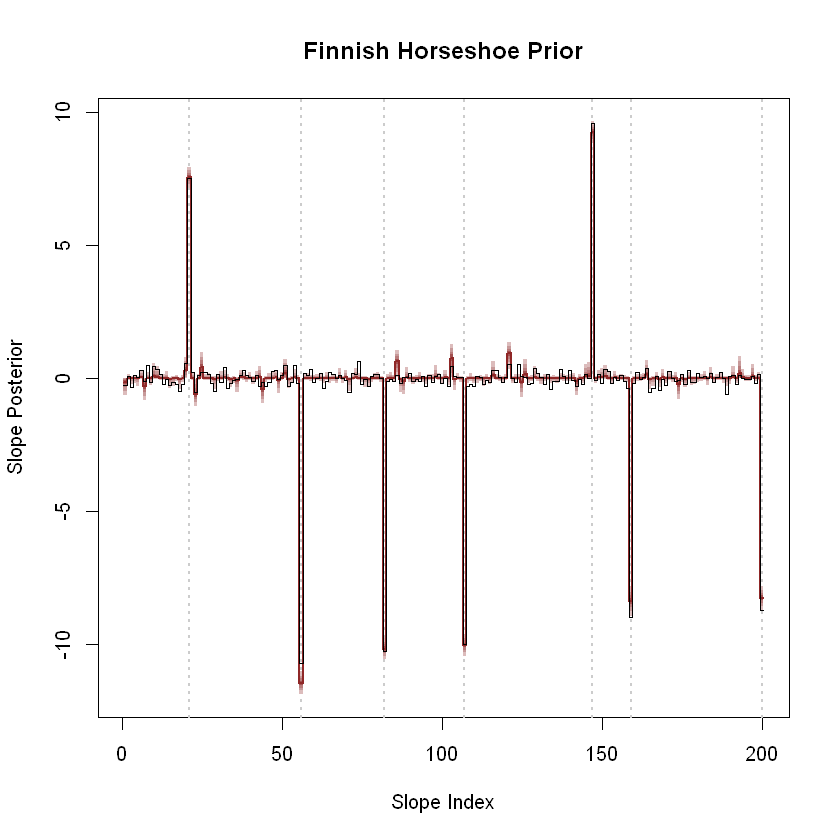

In [56]:
util$plot_post_quantiles(finnish_fit, input_data, "Finnish Horseshoe Prior")


In particular, the marginal posterior residuals show no sign of a poor fit.



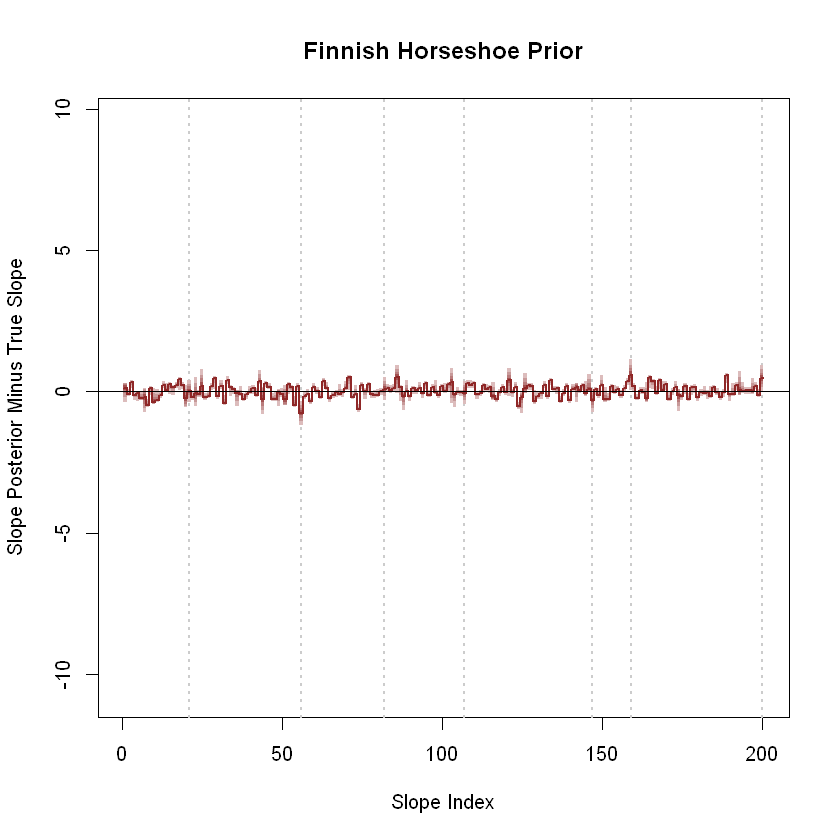

In [57]:
util$plot_residual_quantiles(finnish_fit, input_data, "Finnish Horseshoe Prior")

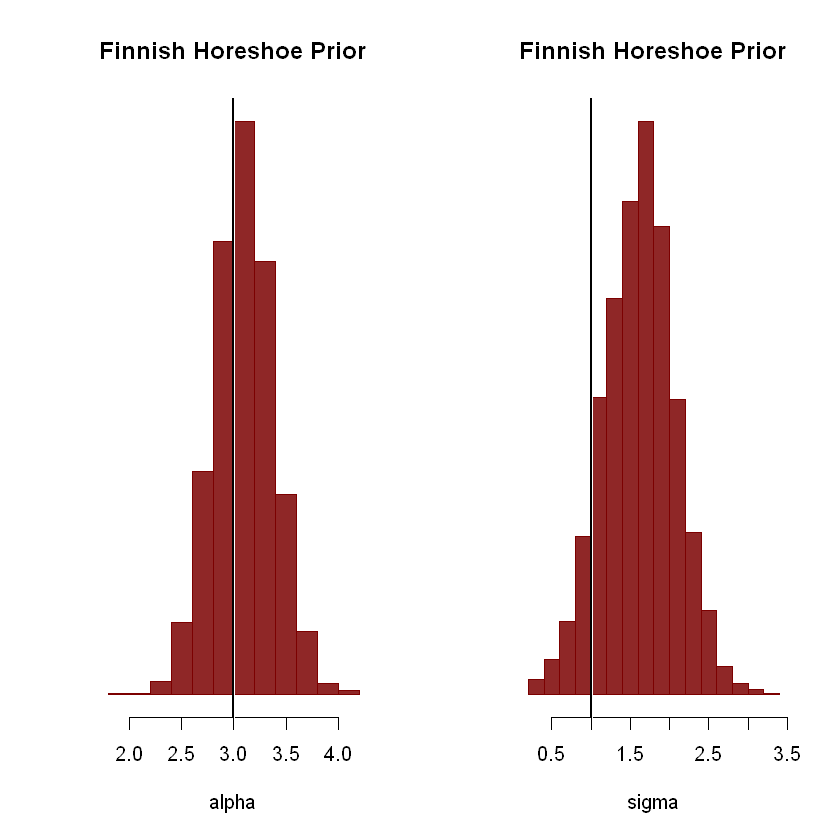

In [58]:
util$plot_aux_posteriors(finnish_fit, "Finnish Horeshoe Prior")

## Comparison

To emphasize the relative performance of the candidate sparsity-inducing
priors let's compare the marginal posterior residuals for only the slopes,
$\left\{ \beta_{51}, \ldots, \beta_{100} \right\}$, using the same plotting
ranges.

As expected the Laplace prior achieves some inferential sparsity in the
posterior but the relevant slopes show signs of overregularization and the
irrelevant slopes show signs of over overregularization.

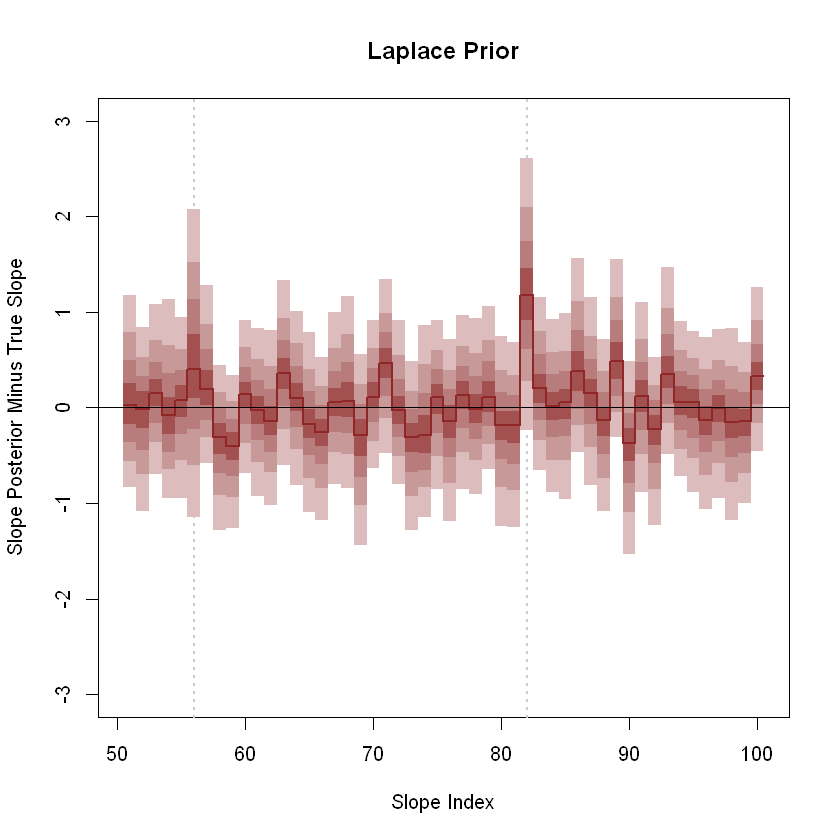

In [59]:
util$plot_summary_residual_quantiles(laplace_fit, input_data,"Laplace Prior")

Because of the non-identified likelihood the horseshoe prior yields a complex posterior that Stan isn't able to accurately fit, but what we do recover exhibits extreme overregularization of the relevant slopes.

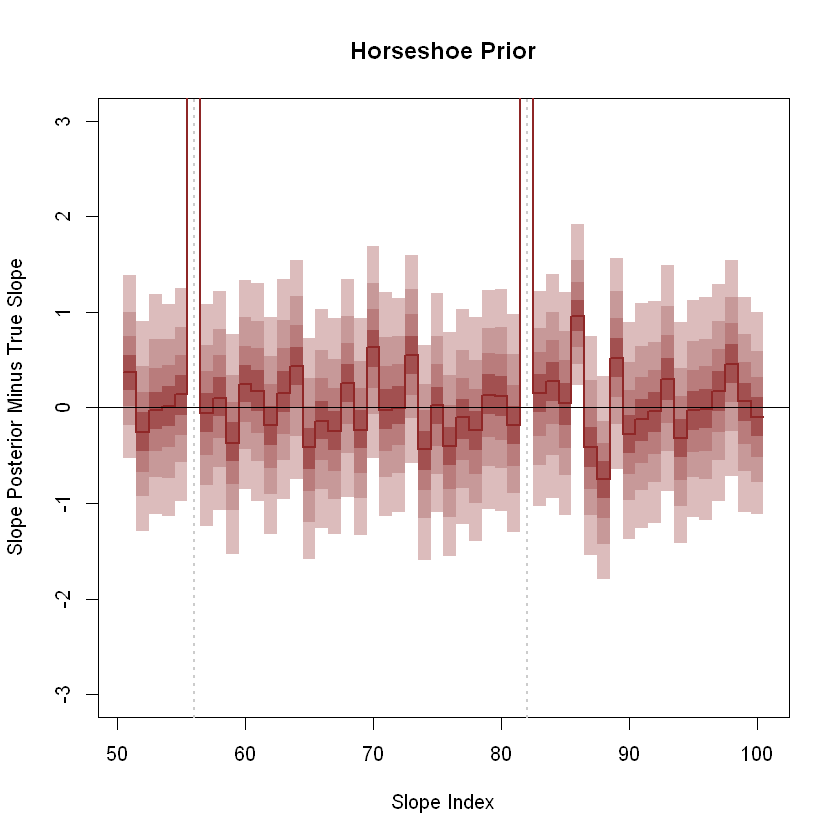

In [60]:
util$plot_summary_residual_quantiles(horseshoe_fit, input_data,"Horseshoe Prior")

By regularizing the extent of the relevant slopes in addition to the irrelevant slopes, the Finnish horseshoe ensures an identified posterior that exhibits exactly the dichotomous regularization we need to properly induce sparsity.

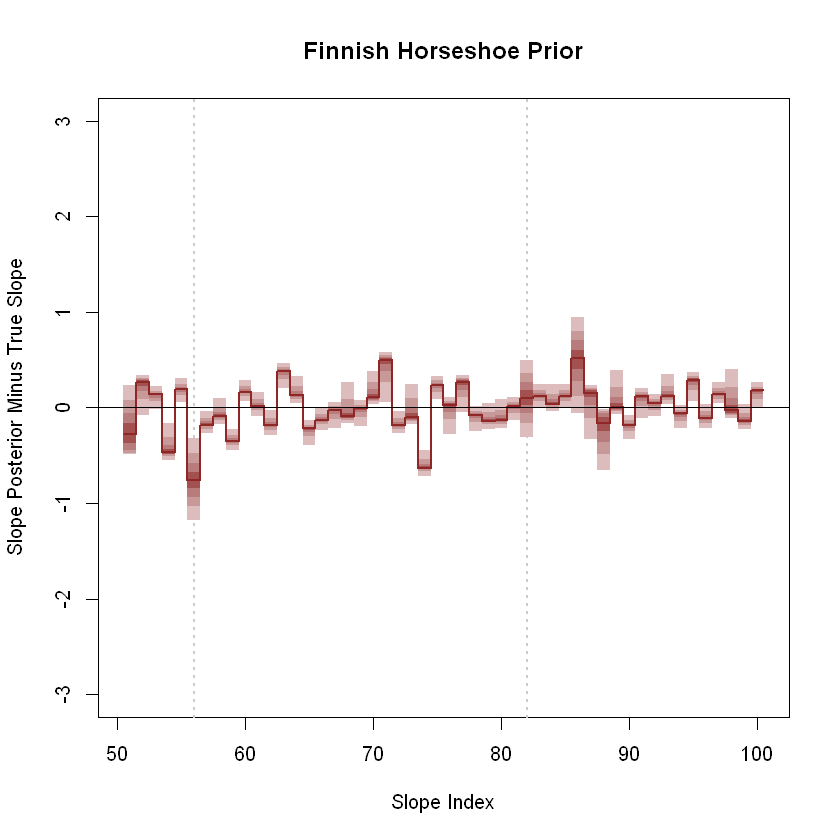

In [61]:
util$plot_summary_residual_quantiles(finnish_fit, input_data,"Finnish Horseshoe Prior")

# Conclusion

Sparsity is a potentially powerful but ultimately quite subtle assumption. Only by utilizing prior distributions that induce sparsity in a principled manner can we truly exploit the assumption of sparsity in those circumstances where it is appropriate.  In particular, any proper application of sparsity requires a detailed understanding of how the sparse parameters effect the
measurement process.

Finally, sparse inferences and sparse decisions are not mutually exclusive. Indeed inferential sparsity is critical for enabling robust sparse decisions in a Bayesian framework.  For example, [PiironenEtAl:2017b](@PiironenEtAl:2017b) use inferential sparsity to faciliate variable selection that minimizes the loss of predictive performance.

# Acknowledgements

I thank Dan Simpson, Aki Vehtari, and Juho Piironen for many helpful conversations about sparsity and comments on this case study.

# Original Computing Environment

In [62]:
writeLines(readLines(file.path(Sys.getenv("HOME"), ".R/Makevars")))

Warning message in readLines(file.path(Sys.getenv("HOME"), ".R/Makevars")):
"incomplete final line found on 'C:/R/R-4.2.0/.R/Makevars'"


CXX=C:/R/rtools42/x86_64-w64-mingw32.static.posix/bin/g++.exe
CXX14FLAGS=-O3 -mtune=native -mmmx -msse -msse2 -msse3 -mssse3 -msse4.1 -msse4.2 
CXX11FLAGS=-O3 -mtune=native -mmmx -msse -msse2 -msse3 -mssse3 -msse4.1 -msse4.2


In [63]:
devtools::session_info("rstan")

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.2.0 (2022-04-22 ucrt)
 os       Windows 10 x64 (build 22000)
 system   x86_64, mingw32
 ui       RTerm
 language (EN)
 collate  English_United Kingdom.utf8
 ctype    English_United Kingdom.utf8
 tz       Europe/Paris
 date     2022-05-01
 pandoc   2.12 @ C:\\ANACON~1\\Scripts\\pandoc.exe

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 ! package      * version   date (UTC) lib source
   backports      1.4.1     2021-12-13 [1] CRAN (R 4.1.2)
   BH             1.78.0-0  2021-12-15 [1] CRAN (R 4.2.0)
   callr          3.7.0     2021-04-20 [1] CRAN (R 4.1.1)
   checkmate      2.1.0     2022-04-21 [1] CRAN (R 4.2.0)
   cli            3.3.0     2022-04-25 [1] CRAN (R 4.2.0)
   colorspace     2.0-3     2022-02-21 [1] CRAN (R 4.1.2)
   crayon         1.5.1     2022-03-26 [1] CRAN (R 4.1.2)
   curl           4.3.2     2021-06-23 [1] CRAN (R 4.1.1)
   desc           1.4.1     2022-03-06 [1] CRAN (R 4.1.3)
   digest         0.6.29    2021-12-01 [1] CRAN (R 4.1.2)
   ellipsis       0.3.2     2021-04-29 [1] CRAN (R 4.1.1)
   fansi          1.0.3     2022-03-24 [1] CRAN (R 4.1.2)
   farver         2.1.0     2021-02-28 [1] CRAN (R 4.1.1)
   ggplot2        3.3.5     2021-06-25 [1] CRAN (R 4.1.1)
   glue           1.6.2     2022-02-24 [1] CRAN (R 4.1.2)
   gridExtra      2.3       2017-09-09 [1] CRAN (R 4.1.1)
   gtable         0.3.0     2019-03-25 [1] CRAN (R 4.1.1)
   inline         0.3.19    2021-05-31 [1] CRAN (R 4.2.0)
   isoband        0.2.5     2021-07-13 [1] CRAN (R 4.1.1)
   jsonlite       1.8.0     2022-02-22 [1] CRAN (R 4.1.2)
   labeling       0.4.2     2020-10-20 [1] CRAN (R 4.1.1)
   lattice        0.20-45   2021-09-22 [1] CRAN (R 4.2.0)
   lifecycle      1.0.1     2021-09-24 [1] CRAN (R 4.1.1)
   loo            2.5.1     2022-03-24 [1] CRAN (R 4.1.2)
   magrittr       2.0.3     2022-03-30 [1] CRAN (R 4.2.0)
   MASS           7.3-57    2022-04-22 [1] CRAN (R 4.2.0)
   Matrix         1.4-1     2022-03-23 [1] CRAN (R 4.2.0)
   matrixStats    0.62.0    2022-04-19 [1] CRAN (R 4.2.0)
   mgcv           1.8-40    2022-03-29 [1] CRAN (R 4.2.0)
   munsell        0.5.0     2018-06-12 [1] CRAN (R 4.1.1)
   nlme           3.1-157   2022-03-25 [1] CRAN (R 4.2.0)
   pillar         1.7.0     2022-02-01 [1] CRAN (R 4.1.2)
   pkgbuild       1.3.1     2021-12-20 [1] CRAN (R 4.1.2)
   pkgconfig      2.0.3     2019-09-22 [1] CRAN (R 4.1.1)
   prettyunits    1.1.1     2020-01-24 [1] CRAN (R 4.1.1)
   processx       3.5.3     2022-03-25 [1] CRAN (R 4.1.2)
   ps             1.7.0     2022-04-23 [1] CRAN (R 4.2.0)
   R6             2.5.1     2021-08-19 [1] CRAN (R 4.1.1)
   RColorBrewer   1.1-3     2022-04-03 [1] CRAN (R 4.2.0)
   Rcpp           1.0.8.3   2022-03-17 [1] CRAN (R 4.2.0)
   RcppEigen      0.3.3.9.2 2022-04-08 [1] CRAN (R 4.2.0)
 D RcppParallel   5.1.5     2022-01-05 [1] CRAN (R 4.1.2)
   rlang          1.0.2     2022-03-04 [1] CRAN (R 4.1.2)
   rprojroot      2.0.3     2022-04-02 [1] CRAN (R 4.2.0)
   rstan        * 2.26.11   2022-04-26 [1] local
   scales         1.2.0     2022-04-13 [1] CRAN (R 4.2.0)
   StanHeaders  * 2.26.11   2022-04-26 [1] local
   tibble         3.1.6     2021-11-07 [1] CRAN (R 4.1.2)
   utf8           1.2.2     2021-07-24 [1] CRAN (R 4.1.1)
   V8             4.1.0     2022-02-06 [1] CRAN (R 4.1.2)
   vctrs          0.4.1     2022-04-13 [1] CRAN (R 4.2.0)
   viridisLite    0.4.0     2021-04-13 [1] CRAN (R 4.1.1)
   withr          2.5.0     2022-03-03 [1] CRAN (R 4.1.2)

 [1] C:/R/R-4.2.0/library

 D ── DLL MD5 mismatch, broken installation.

──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# References


[CarvalhoEtAl:2009](@CarvalhoEtAl:2009) Carvalho, Carlos M., Nicholas G. Polson, and James G. Scott. 2009. [_"Handling Sparsity via the Horseshoe"._](http://proceedings.mlr.press/v5/carvalho09a.html) In Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics, edited by David van Dyk and Max Welling, 5:73–80. Proceedings of Machine Learning Research. Hilton Clearwater Beach Resort, Clearwater Beach, Florida USA: PMLR.

[GelmanEtAl:2017](@GelmanEtAl:2017) Gelman, Andrew, Daniel Simpson, and Michael Betancourt. 2017. [_"The Prior Can Often Only Be Understood in the Context of the Likelihood"._](doi:10.3390/e19100555) Entropy 19 (10). 

[PiironenEtAl:2017a](@PiironenEtAl:2017a) Piironen, Juho, and Aki Vehtari. 2017a. [_"Sparsity Information and Regularization in the Horseshoe and Other Shrinkage Priors"._](doi:10.1214/17-EJS1337SI) Electron. J. Statist. 11 (2). The Institute of Mathematical Statistics; the Bernoulli Society: 5018–51.

[PiironenEtAl:2017b](@PiironenEtAl:2017b)———. 2017b. [_"Comparison of Bayesian Predictive Methods for Model Selection"._](doi:10.1007/s11222-016-9649-y) Statistics and Computing 27 (3): 711–35. 

[Tibshirani:1996](@Tibshirani:1996)Tibshirani, Robert. 1996.[_"Regression Shrinkage and Selection via the Lasso"._](http://www.jstor.org/stable/2346178) Journal of the Royal Statistical Society. Series B (Methodological) 58 (1). [Royal Statistical Society, Wiley]: 267–88. 